# Crear Red Neural desde las matemáticas

### Importamos las librerias necesarias

In [12]:
import pandas as pd
import numpy as np
import math, random
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearn.datasets import make_circles, make_classification, make_gaussian_quantiles
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, Math, Latex
import time
from IPython.display import clear_output 

### Creamos las funciones necesarias

In [13]:
#Creamos la función sigmoide con lambda , donde lambda[0] es la sigmoide y lambda[1] es su derivada
sigm = (lambda x:1/(1+np.e**(-x)),lambda x:x * (1-x))

#Tangente Hiperbólica y su derivada
cosh = (lambda x: (np.e**(x) + np.e**(-x))/2) #Saco la función de coseno hiperbólico para la derivada de la tangh
tanh = (lambda x: (np.e**(x) - np.e**(-x))/(np.e**(x) + np.e**(-x)), lambda x: 1/cosh(x)**2)

#Relu Rectified Lineal Unit
relu = (lambda x: np.maximum(0,x), lambda x: 1. * (x > 0))

mse_loss= (lambda Yp,Yr: np.mean((Yp-Yr)**2), lambda Yp,Yr: (Yp-Yr))

cross_loss = (lambda Yp,Yr:-np.nanmean(Yr * np.log(Yp) + (1-Yr) * np.log(1-Yp)), 
              lambda Yp,Yr: -(np.divide(Yr,Yp)- np.divide(1-Yr, 1-Yp)))

### Clase para la estrutura de la red neuronal
* Creamos una clase en Python que nos permite crear una red neural de n neuronas y l capas
* Esta clase generará de forma aleatoria los valores de los pesos (W) y el del sesgo (BIAS)

In [14]:
class neural_layer():
    def __init__(self, n_conn, n_neur, act_f):
        self.act_f=act_f
        self.b=np.random.randn(1,n_neur)
        self.w=np.random.randn(n_conn,n_neur)
    

### Creamos nuestra Red
* Creamos una función que usará la clase neural_layer para crear nuestra red neuronal
* Además a esta red le pasaremos la función de activación en las capas ocultas y en la capa de salida

In [15]:
def create_nn(topology, act_f, last_f=sigm):
    nn=[]
    for l, layer in enumerate(topology[:-1]):
        if l+1 is len(topology[:-1]): # Añadimos a la ultima capa la función de activación distinta
            nn.append(neural_layer(topology[l],topology[l+1],last_f))
        else:
            nn.append(neural_layer(topology[l],topology[l+1],act_f))   
    return nn    

## Definimos la función de entrenamiento de nuestra red

In [16]:
#Función de entrenamiento
def train(neural_net, X, Y, f_cost,lr=0.5,train=True):
    out=[(None,X)] # En este array guarda los pares de z y a [(z0,a0),(z1,a1),...]
    
    #Forward Pass
    for l, layer in enumerate(neural_net):
      
        z = np.dot(out[-1][1],neural_net[l].w) + neural_net[l].b
        a = neural_net[l].act_f[0](z)
       
        out.append((z,a))

    
    #Backpropagation and Gradient descent
    
    if train:
        delta=[]
        
        for l in reversed(range(0,len(neural_net))):
            z=out[l+1][0]
            a=out[l+1][1]
            
            #Si estamos en la ultima capa
            if l == len(neural_net) - 1:
                delta.insert(0, f_cost[1](a, Y) * neural_net[l].act_f[1](a))
            #Calculamos delta en las capas previas
            else:
                delta.insert(0,np.dot(delta[0],aux_w.T) * neural_net[l].act_f[1](a)) 
                #Cuidado con los indices de las capas, son distinos (1+) en el array Out
                
            aux_w=neural_net[l].w 
            #Lo guardamos en una variable auxiliar para poder modificar los valores al mismo tiempo usando el Gradiente descendente
                
            #Gradient Descent : Ajuste de los pesos y el valor BIAS
            neural_net[l].b = neural_net[l].b - lr * np.mean(delta[0], axis=0, keepdims=True)
            #Hago la media de los valores que tengo en el vector de Bias y con keepdims conservo su dimensión
            neural_net[l].w = neural_net[l].w - np.dot(out[l][1].T,delta[0])*lr
    return out[-1][1] 

## Entrenamos nuestra red neuronal

### Creamos el dataset
#### Make Circles
* Crear un círculo grande que contenga un círculo más pequeño en 2d.
* Un conjunto de datos simple para visualizar algoritmos de agrupamiento y clasificación.
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html?highlight=make%20circles#sklearn.datasets.make_circles

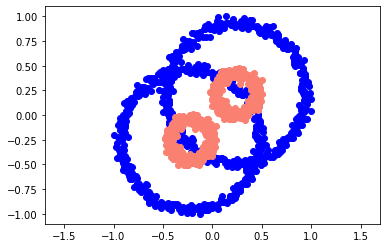

In [17]:
n=800 #número de puntos utilizados en el dataset
X, Y = make_circles(n_samples=n, noise=0.04, shuffle=True, factor=0.3)
Y = Y[:,np.newaxis] #Le genero una dimensión a los valores de Y para poder operar con ellos en train

#Creamos dos circulos para realziar un aprendizaje un poco más complejo
# Al circulo original le sumammos una constante aleatoria entre 2 y 4 para desplazarla en el eje
X=X+random.uniform(-2,4)
X_1=X+random.uniform(-2,4)

#unimos ambos arrays
Y=np.concatenate((Y,Y), axis=0)
X=np.concatenate((X,X_1),axis=0)

#Escalamos los valores entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

#Mezclamos los valores dentro del array para evitar el posible patrón de suma de la constante
state=np.random.get_state()
np.random.shuffle(X)
#Guardamos el esto aleatorio para plicarlo igual en la Y y así mantener la clasificación del circulo exterior e interior
np.random.set_state(state) 
np.random.shuffle(Y)

#Dibujamos ambos circulos
plt.scatter(X[Y[:,0]==0,0],X[Y[:,0]==0,1],color="blue")
plt.scatter(X[Y[:,0]==1,0],X[Y[:,0]==1,1],color="salmon")
plt.axis("equal")
plt.show()

### Creamos la estructura de la red neuronal que aprenderá a clasificar este dataset
* ***Topology*** : Estructura de capas que tendrá nuestrad
* ***create_nn*** : Función que crea nuestra red pasando las funciones de activación (capas ocultas y capa de salida)
* ***f_loss*** : Función de perdida que usaremos (MSE ó Entropía cruzada binaria)
* ***epochs*** : Número de épocas de nuestra red, es decir, el número de veces que realzizrá la retropropagación
* ***lr*** : Ratio de aprendizaje, parametro por el cual avanza nuestro algoritmo en la función de coste

In [18]:
topology=[2,12,6,1] #Recuerda que la primera capa debe ser igual al número de clases que tienes que clasificar
neural_n=create_nn(topology,relu,sigm)
f_loss=cross_loss
epochs=1500
lr=0.0001

### Ejecutamos el entrenamiento

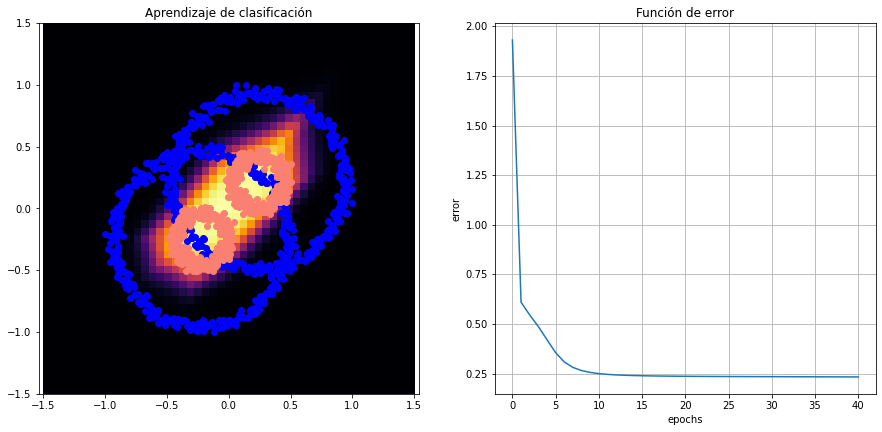

KeyboardInterrupt: 

In [19]:
loss=[] #Array donde guardaremos los errores de las sucesivas interacciones

for i in range(epochs):
    pY=train(neural_n,X,Y,f_loss,lr)
    if i %25 == 0:
        loss.append(f_loss[0](pY,Y))
        
        res=50
        
        _x0 = np.linspace(-1.5,1.5, res)
        _x1 = np.linspace(-1.5,1.5, res)
        
        _Y = np.zeros((res,res))
        
        for i0, x0 in enumerate(_x0):
            for i1, x1 in enumerate(_x1):
                    _Y[i0, i1] = train(neural_n, np.array([[x0,x1]]), Y, f_loss,train=False)[0][0]
        
        plt.figure(1,figsize=(15,15))
        plt.subplot(221)
        plt.title("Aprendizaje de clasificación")        
        plt.pcolormesh(_x0, _x1, _Y, cmap="inferno")
        plt.axis("equal")

        plt.scatter(X[Y[:,0]==0,0],X[Y[:,0]==0,1],color="blue")
        plt.scatter(X[Y[:,0]==1,0],X[Y[:,0]==1,1],color="salmon")
        
        clear_output(wait=True)
        plt.subplot(222)
        plt.title("Función de error")
        plt.xlabel("epochs")
        plt.ylabel("error")
        plt.grid()
        plt.plot(range(len(loss)),loss)
        plt.show()
        time.sleep(0.5)